## Import Libraries

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity =  "all"

In [13]:
# import libraries

# import data manipulation libraries:
import pandas as pd
import numpy as np

# import visualization libraries:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# import machine learning libraries:
from scipy import stats

# import data preprocessing libraries:
import sqlite3
from sqlite3 import Error
import statsmodels.api as sm

import scipy

## Load Data from Database

In [14]:
# load the all the tables in the database to corresponding dataframes:

# set the path to the database:
data_path = '../data/'
database_name = "city_bikes_stations_POIs_foursquare_yelp.sqlite"


In [15]:

# defining the conect function:
def create_connection(path):
    conn = None
    try:
        conn = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return conn

In [16]:
# create a connection to the database:
conn = create_connection(data_path+database_name)

Connection to SQLite DB successful


In [17]:
# list all the tables in the database:
df_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
df_tables

,name
0,target_city_stations_DF
1,DF_POI_FS
2,DF_stations_yelp_POIs_Charac_pivot
3,DF_yelp_stations_POIs_pivot


In [18]:
# draft above:

In [19]:
# read from the database, and create a dataframe for each table, the same variable name as the table name:
table_list = df_tables['name'].to_list()
for name in table_list:
    globals()[name] = pd.read_sql_query("SELECT * from "+name, conn)
    

## Build a regression model.

### Define a Backward Elimination Linear Regression Function

In [20]:
# ## Feature Selection: Backward elemination (P-value approach)
# define the backward elemination function (P-value approach) for linear regression
# input: dataframes DF the input, col_list the list of columns to be used in the regression, dep_var the dependent variable

def backward_elimination_linear_regression(DF, col_list, dep_var, threshold=0.0001):
    """ Takes in the dataframe, the list of columns and the dependent variable, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""
    while len(col_list)>0 :
        X = DF[col_list]
        # add a constant to the dataframe
        # model=sm.OLS(dep_var,sm.add_constant(DF[col_list]))
        model=sm.OLS(dep_var, X)
        result=model.fit()
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(threshold):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)


## Building a Model
To investigate the relationship between the number of bikes in a particular location and the characteristics of the POIs in that location.  
* dependent variable: number of free bikes
* independent variables:  'POI_distance_mean', 'POI_is_closed_mean', 'POI_price_mean', 'POI_rating_mean', 'POI_review_count_mean'

In [21]:
# list the numerical columns of DF_yelp_stations_POIs_pivot
numerical_columns = DF_stations_yelp_POIs_Charac_pivot.select_dtypes(include=['float64', 'int64']).columns

numerical_columns_index = pd.Index(numerical_columns)

numerical_columns_index

# list the columns type: boolean
categorical_columns = DF_stations_yelp_POIs_Charac_pivot.select_dtypes(include=['bool', 'object']).columns
categorical_columns

Index(['station_latitude', 'station_longitude', 'station_empty_slots',
       'station_free_bikes', 'station_uid', 'station_normal_bikes',
       'station_has_ebikes', 'station_ebikes', 'station_slots',
       'station_renting', 'station_returning', 'station_last_updated',
       'POI_distance_mean', 'POI_is_closed_mean', 'POI_price_mean',
       'POI_rating_mean', 'POI_review_count_mean'],
      dtype='object')

Index(['station_id', 'station_name', 'station_timestamp'], dtype='object')

In [22]:
# subste the numerical columns of
DF_stations_yelp_POIs_Charac_pivot_numerical = DF_stations_yelp_POIs_Charac_pivot[['station_empty_slots',
       'station_free_bikes', 'station_normal_bikes',
       'station_ebikes', 'station_slots',
       'POI_distance_mean', 'POI_is_closed_mean', 'POI_price_mean',
       'POI_rating_mean', 'POI_review_count_mean']]

DF_yelp_stations_POIs_pivot_categorical = DF_yelp_stations_POIs_pivot[['station_has_ebikes', 'station_renting', 'station_returning']]

In [23]:
# # show a pairplot
# sns.pairplot(DF_stations_yelp_POIs_Charac_pivot_numerical)
# plt.show();

In [24]:
# find the Nan or Null  values in the numerical columns of DF_yelp_stations_POIs_pivot, show the percentage of missing values in each column, sorted in descending order

DF_stations_yelp_POIs_Charac_pivot_numerical.isnull().sum().sort_values(ascending=False)

station_empty_slots      0
station_free_bikes       0
station_normal_bikes     0
station_ebikes           0
station_slots            0
POI_distance_mean        0
POI_is_closed_mean       0
POI_price_mean           0
POI_rating_mean          0
POI_review_count_mean    0
dtype: int64

## Regression Model 1 - Linear Regression

Starting with all independent variables, we will use backward elimination to remove insignificant variables.

In [25]:
y = DF_stations_yelp_POIs_Charac_pivot_numerical['station_free_bikes']
X = DF_stations_yelp_POIs_Charac_pivot_numerical.drop(['station_free_bikes'], axis=1)
X = sm.add_constant(X)
# X
x_cols = pd.Index([ 'const', 'POI_distance_mean', 
       'POI_price_mean', 'POI_rating_mean', 'POI_review_count_mean'])


In [26]:
X.columns
x_cols

Index(['const', 'station_empty_slots', 'station_normal_bikes',
       'station_ebikes', 'station_slots', 'POI_distance_mean',
       'POI_is_closed_mean', 'POI_price_mean', 'POI_rating_mean',
       'POI_review_count_mean'],
      dtype='object')

Index(['const', 'POI_distance_mean', 'POI_price_mean', 'POI_rating_mean',
       'POI_review_count_mean'],
      dtype='object')

In [27]:
result=backward_elimination_linear_regression(X, x_cols, y)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     station_free_bikes   R-squared (uncentered):                   0.732
Model:                            OLS   Adj. R-squared (uncentered):              0.731
Method:                 Least Squares   F-statistic:                              657.1
Date:                Mon, 27 Feb 2023   Prob (F-statistic):                    1.16e-70
Time:                        14:29:09   Log-Likelihood:                         -743.97
No. Observations:                 241   AIC:                                      1490.
Df Residuals:                     240   BIC:                                      1493.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
POI_price_mean     4.7034      0.183     25.634      0.000       4.342       5.065
==============================================================================
Omnibus:                       35.280   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.370
Skew:                           0.978   Prob(JB):                     8.53e-11
Kurtosis:                       3.888   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

examine the results of the regression model:

In [28]:
residuals = result.resid
residuals

0      12.847419
1      -1.119462
2       4.423190
3      -6.510936
4       0.510915
         ...    
236     2.533858
237     6.328195
238    -7.673988
239    -6.564422
240    -2.062672
Length: 241, dtype: float64

Examining the residual's normality:
* From the histogram, we can see that the residual highly screwed and it is not normally distributed.

<AxesSubplot:ylabel='Count'>

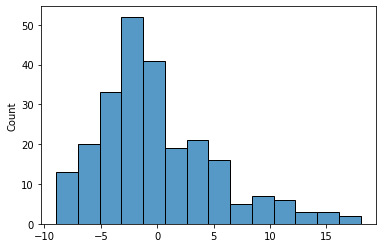

In [29]:
sns.histplot(residuals)

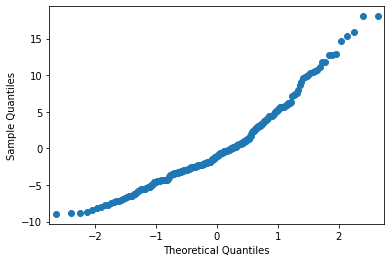

In [30]:
sm.qqplot(residuals)
plt.show();

The qqplot shows that the residuals are not normally distributed, since most of the dots are not on diagonal line.

In [31]:
scipy.stats.shapiro(residuals) 

ShapiroResult(statistic=0.937570333480835, pvalue=1.3401558085490706e-08)

The shapiro test shows that the data is not normally distributed. 


#### Homoscedasticity
For the homoscedasticity assumption to be satisfied, the variance of the residuals should not change as the indep. variable changes. We can view this visually by plotting the residuals vs the indep. variable (income).

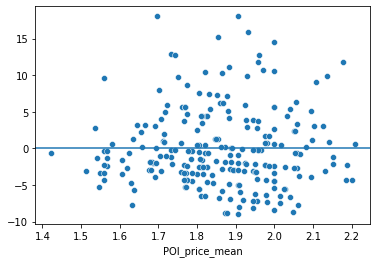

In [32]:

ax = sns.scatterplot(x=DF_stations_yelp_POIs_Charac_pivot_numerical['POI_price_mean'], y=residuals)
ax.axhline(0) #horizontal line at 0

By using the scatter plot, we can see that the variance of the residuals is not constant. The variance of the residuals is larger when the income is smaller. This violates the homoscedasticity assumption. We can also check this by using the Breusch-Pagan test.


#### Breusch-Pagan test (among others) to formally test homoscedasticity.
- H<sub>0</sub>: Homoscedasticity is present (the residuals are distributed with equal variance)
- H<sub>a</sub>: Homoscedasticity is not present(the residuals are not distributed with equal variance)

In [33]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,result.model.exog)
print(p,f_p) #actually performs two tests, so it returns two p-values

nan 1.4535072847276046e-17


By using the Breusch-Pagan test, we can see that the p-value is 0.000, which is less than 0.05. Therefore, we reject the null hypothesis and conclude that the residuals are not homoscedastic.


Conclusion: Both the normality and homoscedasticity assumptions are violated. We can use the log transformation to make it more normal.

## Regression Model 2 - Run linear regression using the log of the dep. variable

The purpose of transforming the dependent variable is to make the residuals more normally distributed.

To ensure the log works, we need to ensure there is no zero value in the dep. variable. 


In [34]:
y = DF_stations_yelp_POIs_Charac_pivot_numerical['station_free_bikes']
y.min()
y.max()

0

27

Drop the rows with zero value in the dep. variable:

In [35]:
DF_stations_yelp_POIs_Charac_pivot_numerical_drop0 = DF_stations_yelp_POIs_Charac_pivot_numerical.copy()
# Delete the rows station_free_bikes = 0
DF_stations_yelp_POIs_Charac_pivot_numerical_drop0 = DF_stations_yelp_POIs_Charac_pivot_numerical_drop0[DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['station_free_bikes']!=0]
DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['station_free_bikes'].min()
DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['station_free_bikes'].max()

1

27

Building the regression model using the log of the dep. variable:

In [36]:
y = np.log(DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['station_free_bikes'])
X = DF_stations_yelp_POIs_Charac_pivot_numerical_drop0.drop(['station_free_bikes'], axis=1)
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept
x_cols = pd.Index(['POI_is_closed_mean',
       'POI_price_mean', 'POI_rating_mean', 'POI_review_count_mean'])


In [37]:
result=backward_elimination_linear_regression(X, x_cols, y)
print(result.summary())
residuals = result.resid

                                 OLS Regression Results                                
Dep. Variable:     station_free_bikes   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                              2240.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):                   1.93e-122
Time:                        14:29:11   Log-Likelihood:                         -233.60
No. Observations:                 237   AIC:                                      469.2
Df Residuals:                     236   BIC:                                      472.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/Users/ds/opt/anaconda3/envs/THE_ONE/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


### Normality Test

In [38]:

scipy.stats.shapiro(residuals)

ShapiroResult(statistic=0.981182336807251, pvalue=0.0030757205095142126)

The Shapiro test shows that the data is not normally distributed.

### Homoscedasticity Test

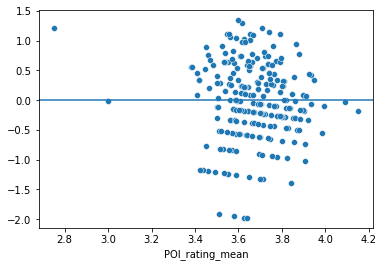

In [39]:
ax = sns.scatterplot(x=DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['POI_rating_mean'], y=residuals)
ax.axhline(0) #horizontal line at 0

The scatter plot shows that the variance of the residuals is not constant. This violates the homoscedasticity assumption. 


## Regression Model 3 - Run linear regression using the square root of the dep. variable

Use the square root of the dep. variable:

In [40]:
y = np.sqrt(DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['station_free_bikes'])
X = DF_stations_yelp_POIs_Charac_pivot_numerical_drop0.drop(['station_free_bikes'], axis=1)
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept
x_cols = pd.Index(['POI_is_closed_mean',
       'POI_price_mean', 'POI_rating_mean', 'POI_review_count_mean'])


In [41]:
result=backward_elimination_linear_regression(X, x_cols, y)
print(result.summary())
residuals = result.resid

                                 OLS Regression Results                                
Dep. Variable:     station_free_bikes   R-squared (uncentered):                   0.915
Model:                            OLS   Adj. R-squared (uncentered):              0.915
Method:                 Least Squares   F-statistic:                              2556.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):                   1.33e-128
Time:                        14:29:12   Log-Likelihood:                         -302.38
No. Observations:                 237   AIC:                                      606.8
Df Residuals:                     236   BIC:                                      610.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/Users/ds/opt/anaconda3/envs/THE_ONE/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


### Normality Test

In [42]:

scipy.stats.shapiro(residuals)


ShapiroResult(statistic=0.9926595091819763, pvalue=0.28940531611442566)

When using the square-root Shapiro test shows that the data is normally distributed.


Let's double-check the normality assumption by using the histplot and qqplot:

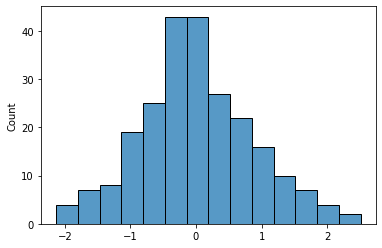

In [43]:
# histogram of the residuals
sns.histplot(residuals)
plt.show();

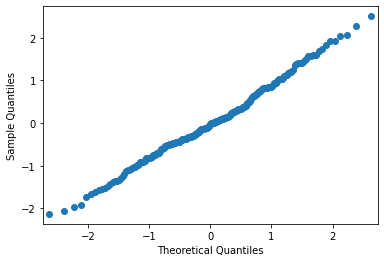

In [44]:
# qqplot of the residuals:
sm.qqplot(residuals)
plt.show();

From the histogram and qqplot, we can see that the residual is normally distributed.

### Homoscedasticity Test

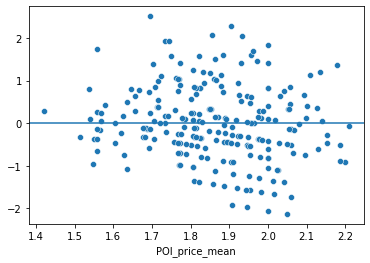

In [45]:
ax = sns.scatterplot(x=DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['POI_price_mean'], y=residuals)
ax.axhline(0) #horizontal line at 0

#### Breusch-Pagan test (among others) to formally test homoscedasticity.
- H<sub>0</sub>: Homoscedasticity is present (the residuals are distributed with equal variance)
- H<sub>a</sub>: Homoscedasticity is not present(the residuals are not distributed with equal variance)

In [46]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,result.model.exog)
print(p,f_p) #actually performs two tests, so it returns two p-values

3.7009600174172566e-19 6.84954026804474e-23


From the scatter plot and Breusch-Pagan test, we can see that the variance of the residuals is not constant. This violates the homoscedasticity assumption.

## Regression Model 4 - Run linear regression using the cube square of the dep. variable

Building the regression model using the cube square of the dep. variable:

In [47]:
y = y = np.cbrt(DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['station_free_bikes'])
X = DF_stations_yelp_POIs_Charac_pivot_numerical_drop0.drop(['station_free_bikes'], axis=1)
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept
x_cols = pd.Index(['POI_is_closed_mean',
       'POI_price_mean', 'POI_rating_mean', 'POI_review_count_mean'])

result=backward_elimination_linear_regression(X, x_cols, y)
print(result.summary())
residuals = result.resid

                                 OLS Regression Results                                
Dep. Variable:     station_free_bikes   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              5398.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):                   1.34e-164
Time:                        14:29:13   Log-Likelihood:                         -128.33
No. Observations:                 237   AIC:                                      258.7
Df Residuals:                     236   BIC:                                      262.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

/Users/ds/opt/anaconda3/envs/THE_ONE/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


### Normality Test

In [48]:
scipy.stats.shapiro(residuals)


ShapiroResult(statistic=0.9905505180358887, pvalue=0.1269000768661499)

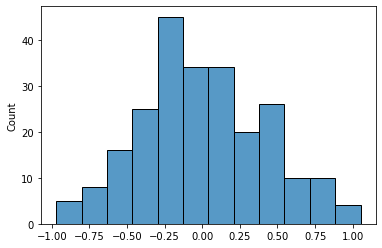

In [49]:
# histogram of the residuals
sns.histplot(residuals)
plt.show();

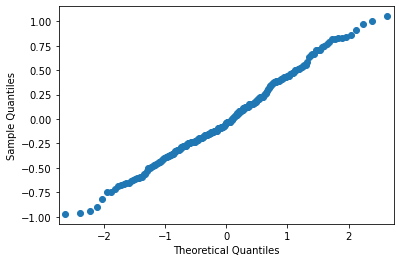

In [50]:
# qqplot of the residuals:
sm.qqplot(residuals)
plt.show();

### Homoscedasticity Test


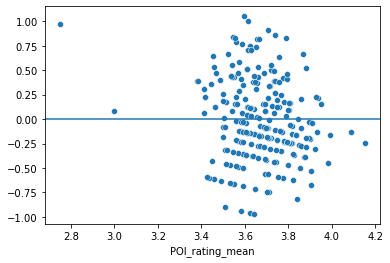

In [51]:
ax = sns.scatterplot(x=DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['POI_rating_mean'], y=residuals)
ax.axhline(0) #horizontal line at 0

### Breusch-Pagan test


In [52]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,result.model.exog)
print(p,f_p) #actually performs two tests, so it returns two p-values

1.4691905882422536e-20 4.940312429066477e-25


The result from cube square method is not as good as the square root method. Therefore, we will use the square root of the dep. variable.


By comparison, we can see that the free bike numbers is related to either the avarage Yelp ratings or the average Yelp price.

| Dep. Var. Transform | Indepedant Variable |Coefficient | p-value  | Normality Assumption | Homoscedacity Assumption |
| --- | --- | --- | --- | --- | --- |
| linear | POI_price_mean | 4.7034 | 0.000 |  No | No |
| log | POI_rating_mean  |0.5438 | 0.000 | No | No |
| square root | POI_price_mean | 1.5285 | 0.000 | Yes | No |
| cube root | POI_rating_mean | 0.5415 | 0.000 | Yes | No |





## Model 5 - p-value threshold 0.05 while using the square root of the dep. variable


Set the threshold to 0.05:

In [53]:
y = np.sqrt(DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['station_free_bikes'])
X = DF_stations_yelp_POIs_Charac_pivot_numerical_drop0.drop(['station_free_bikes'], axis=1)
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept
x_cols = pd.Index(['POI_price_mean', 'POI_rating_mean', 'POI_review_count_mean'])


In [54]:
result=backward_elimination_linear_regression(X, x_cols, y, 0.05)
print(result.summary())
residuals = result.resid

                                 OLS Regression Results                                
Dep. Variable:     station_free_bikes   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.916
Method:                 Least Squares   F-statistic:                              1300.
Date:                Mon, 27 Feb 2023   Prob (F-statistic):                   8.16e-128
Time:                        14:29:14   Log-Likelihood:                         -300.03
No. Observations:                 237   AIC:                                      604.1
Df Residuals:                     235   BIC:                                      611.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

This time return the both the two possible independent variables: POI_price_mean and POI_rating_mean.

# Normality Test


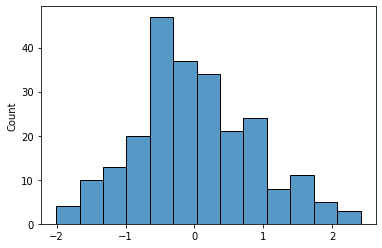

In [55]:
# histogram of the residuals
sns.histplot(residuals)
plt.show();

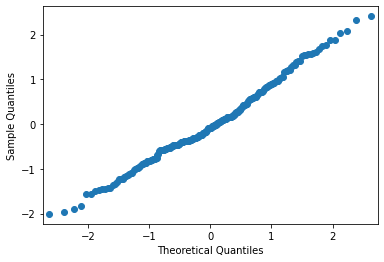

In [56]:
# qqplot of the residuals:
sm.qqplot(residuals)
plt.show();

# Homoscedasticity Test

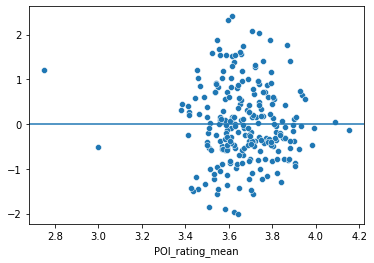

In [57]:
# Scatterplot of the residuals
ax = sns.scatterplot(x=DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['POI_rating_mean'], y=residuals)
ax.axhline(0) #horizontal line at 0

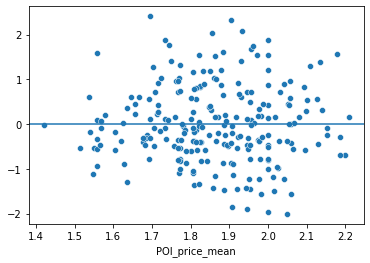

In [58]:
ax = sns.scatterplot(x=DF_stations_yelp_POIs_Charac_pivot_numerical_drop0['POI_price_mean'], y=residuals)
ax.axhline(0) #horizontal line at 0

### Breusch-Pagan test


In [59]:
stat, p, f_stat, f_p = sm.stats.diagnostic.het_breuschpagan(residuals,result.model.exog)
print(p,f_p) #actually performs two tests, so it returns two p-values

4.231317966505942e-20 3.673384316602147e-23


The homoscedasticity assumption is violated. 

# Stretch

How can you turn the regression model into a classification model?

We can use the ratio of free bikes to all slots as the indicator for the poplarity of the station. Then we can set a threshold to classify the stations into two groups: high-popular and low-popular.

In [60]:
DF_stations_yelp_POIs_Charac_pivot_numerical.columns
DF_stations_yelp_POIs_Charac_pivot_numerical.shape

Index(['station_empty_slots', 'station_free_bikes', 'station_normal_bikes',
       'station_ebikes', 'station_slots', 'POI_distance_mean',
       'POI_is_closed_mean', 'POI_price_mean', 'POI_rating_mean',
       'POI_review_count_mean'],
      dtype='object')

(241, 10)

Examine the distribution of the ratio of free bikes to all slots:

In [61]:
DF_stations_yelp_POIs_Charac_pivot_numerical_categorical = DF_stations_yelp_POIs_Charac_pivot_numerical.copy()

# By define a new column called 'station_free_bikes'/ 'station_slots'
DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['Popularity'] = DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['station_free_bikes']/DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['station_slots']

# show the statistics of the new column

DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['Popularity'].describe()


count    241.000000
mean       0.456273
std        0.223460
min        0.000000
25%        0.300000
50%        0.437500
75%        0.600000
max        1.000000
Name: Popularity, dtype: float64

Since the mean is easily affected by outliers, we can use the median as the threshold to classify the stations into two groups: high-popular and low-popular.


In [62]:
# use the median as an indicator to define the Popularity of the station
# if Popularity > median, substitute the value with 1, otherwise 0
DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['Popularity'] = DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['Popularity'].apply(lambda x: 1 if x > 0.437500 else 0)

Examine the unique values in the 'Popularity' column:

In [63]:
DF_stations_yelp_POIs_Charac_pivot_numerical_categorical.columns
DF_stations_yelp_POIs_Charac_pivot_numerical_categorical.shape
DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['Popularity'].value_counts()

Index(['station_empty_slots', 'station_free_bikes', 'station_normal_bikes',
       'station_ebikes', 'station_slots', 'POI_distance_mean',
       'POI_is_closed_mean', 'POI_price_mean', 'POI_rating_mean',
       'POI_review_count_mean', 'Popularity'],
      dtype='object')

(241, 11)

0    125
1    116
Name: Popularity, dtype: int64

Now we can start working on this classification model by performing the logistic regressions.

The dependant is the Popularity of the station. 




Define a function to perform backward elimination:

In [64]:
# Define a function to perform backward elimination

def backward_elimination_Logit(DF, col_list, dep_var):
    """ Takes in the dataframe, the list of columns and the dependent variable, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""
    while len(col_list)>0 :
        model=sm.Logit(dep_var.astype(float),DF[col_list].astype(float))
        result=model.fit()
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.0001):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

Set up the model:

In [65]:
y = DF_stations_yelp_POIs_Charac_pivot_numerical_categorical['Popularity']
X = DF_stations_yelp_POIs_Charac_pivot_numerical_categorical.drop(['Popularity'], axis=1)
X = sm.add_constant(X) #adds a column of 1's so the model will contain an intercept
x_cols = pd.Index(['POI_is_closed_mean',
       'POI_price_mean', 'POI_rating_mean', 'POI_review_count_mean'])


When running the function, There is a LinAlgError: Singular matrix.

In [66]:
result=backward_elimination_Logit(X, x_cols, y)
print(result.summary())
residuals = result.resid


Optimization terminated successfully.
         Current function value: 0.689861
         Iterations 4


LinAlgError: Singular matrix